In [1]:
# Imports
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import math

# Tensorflow/keras imports
from keras import Sequential
from keras import layers
from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.utils import class_weight
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from category_encoders import BinaryEncoder

import seaborn as sns

In [2]:
# Function for removing correlated features
def remove_correlated_features(df: pd.DataFrame, threshold: float) -> None:
    corr_matrix = df.corr(numeric_only = True)
    #sns.heatmap(corr_matrix)
    #plt.title("Features Correlation")
    #plt.show()
    drop_cols = []
    # Iterate through the correlation matrix and compare correlations
    for i in range(len(corr_matrix.columns) - 1):
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print("Correlated features: ", col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    df.drop(columns=drops, inplace=True)
    print('Removed Columns {}'.format(drops))


def display_confusion_matrix(y_pred, y_test) -> None:
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=np.unique(y_test))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test)).plot(cmap='Blues')
    plt.show()

In [3]:
# Data files
train_set = pd.read_csv("UNSW_NB15_training-set.csv")
test_set = pd.read_csv("UNSW_NB15_testing-set.csv")

df = pd.concat([train_set, test_set])
df = df.drop(columns=['id', 'attack_cat'])

print(f"Samples in df: {len(df)}")

remove_correlated_features(df, 0.98)

X = df.drop(columns=['label'])

# Encode categorical features using binary encoding
# Scale numerical features using standard scaler
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
print(f"Categorical features: {cat_features}")
print(f"Numerical features: {num_features}")

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), num_features),
        ("categorical", BinaryEncoder(handle_unknown="ignore"), cat_features)
    ], sparse_threshold=0
)
X = preprocessor.fit_transform(X)

print(f"Number of features after preprocessing: {X.shape[1]}")

# Create the test set with 30% of the total samples
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Use class weights to balance the classes for the training set
#y_train.value_counts().plot.bar()
#plt.title("Number of samples per label in the training set")
#plt.show()

class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

print(X_train.shape)

Samples in df: 257673
Correlated features:  sloss | sbytes | 1.0
Correlated features:  dloss | dbytes | 1.0
Correlated features:  dwin | swin | 0.98
Correlated features:  ct_ftp_cmd | is_ftp_login | 1.0
Removed Columns {'ct_ftp_cmd', 'dwin', 'dloss', 'sloss'}
Categorical features: ['proto', 'service', 'state']
Numerical features: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
Number of features after preprocessing: 51
(180371, 51)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 51)                2652      
                                                                 
 dropout (Dropout)           (None, 51)                0         
                                                                 
 dense_1 (Dense)             (None, 51)                2652      
                                                                 
 dropout_1 (Dropout)         (None, 51)                0         
                                                                 
 dense_2 (Dense)             (None, 12)                624       
                                                                 
 dense_3 (Dense)             (None, 12)                156       
                                                                 
 dense_4 (Dense)             (None, 1)                 

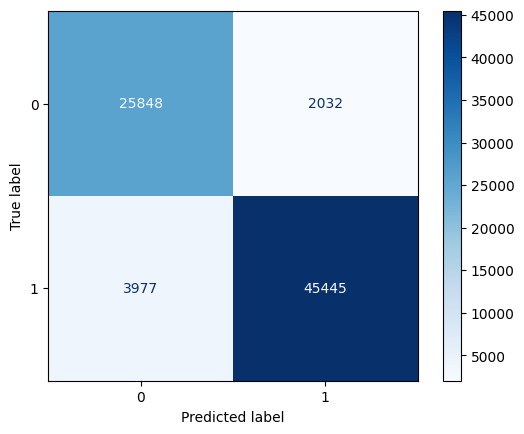

In [4]:
# Hyperparameters
epochs = 10
batch_size = 128
initial_lr = 0.01

# Function which will decrease the lr by 10% every n epochs
def lr_step_decay(epoch, lr):
    epochs_per_drop = 5
    return initial_lr * math.pow(0.9, math.floor(epoch/epochs_per_drop))

# Model

model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(51, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(51, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(12, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(1),
    layers.Activation("sigmoid")
])

model.summary()

# Compile model
model.compile(
    optimizer = SGD(learning_rate=initial_lr, momentum=0.9),
    loss = "binary_crossentropy",
    metrics = ["accuracy", "Recall","Precision"]
)

# Train model with proper callback
model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, class_weight=class_weights, verbose=1, callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)])

# Evaluate on test data
print("\nTest data loss/accuracy:")
print(model.evaluate(X_test, y_test))

# Display confusion matrix
display_confusion_matrix((model.predict(X_test, verbose=0).flatten() > 0.5), y_test)

In [5]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_hats = model.predict(X_train)
y_hats_test = model.predict(X_test)

# Add the predictions to the training set
X_train = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())
X_train['preds'] = y_hats.tolist()
X_test['preds'] = y_hats_test.tolist()

print(X_train.shape)

(180371, 52)



Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/10
1128/1128 [==============================] - 4s 3ms/step - loss: 0.0872 - accuracy: 0.9646 - recall: 0.9642 - precision: 0.9800 - val_loss: 0.0105 - val_accuracy: 0.9978 - val_recall: 0.9975 - val_precision: 0.9990 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/10
1128/1128 [==============================] - 3s 2ms/step - loss: 0.0162 - accuracy: 0.9964 - recall: 0.9961 - precision: 0.9983 - val_loss: 0.0101 - val_accuracy: 0.9976 - val_recall: 0.9972 - val_precision: 0.9991 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/10
1128/1128 [==============================] - 3s 2ms/step - loss: 0.0135 - accuracy: 0.9969 - recall: 0.9965 - precision: 0.9986 - val_loss: 0.0096 - val_accuracy: 0.9978 - val_recall: 0.9975 - val_precision: 0.9991 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/10
1128/1128 [=========

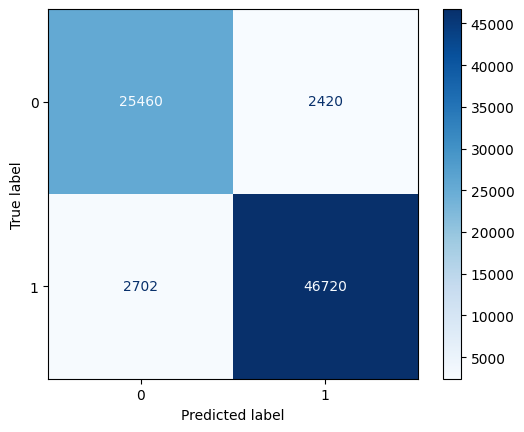

In [6]:
# Hyperparameters
epochs = 10
batch_size = 128
initial_lr = 0.01

# Function which will decrease the lr by 10% every n epochs
def lr_step_decay(epoch, lr):
    epochs_per_drop = 5
    return initial_lr * math.pow(0.9, math.floor(epoch/epochs_per_drop))

# Model

model2 = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(52, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(52, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(12, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(1),
    layers.Activation("sigmoid")
])

#model2.summary()

# Compile model
model2.compile(
    optimizer = SGD(learning_rate=initial_lr, momentum=0.9),
    loss = "binary_crossentropy",
    metrics = ["accuracy", "Recall","Precision"]
)

# Train model with proper callback
model2.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, class_weight=class_weights, verbose=1, callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)])

# Evaluate on test data
print("\nTest data loss/accuracy:")
print(model2.evaluate(X_test, y_test))

# Display confusion matrix
display_confusion_matrix((model2.predict(X_test, verbose=0).flatten() > 0.5), y_test)

In [7]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, random_state=0)
model.fit(X_train, y_train)

y_hats = model.predict(X_train)
y_hats_test = model.predict(X_test)

# Add the predictions to the training set
X_train = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())
X_train['preds'] = y_hats.tolist()
X_test['preds'] = y_hats_test.tolist()

print(X_train.shape)


(180371, 52)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 52)                2756      
                                                                 
 dropout_4 (Dropout)         (None, 52)                0         
                                                                 
 dense_11 (Dense)            (None, 52)                2756      
                                                                 
 dropout_5 (Dropout)         (None, 52)                0         
                                                                 
 dense_12 (Dense)            (None, 12)                636       
                                                                 
 dense_13 (Dense)            (None, 12)                156       
                                                                 
 dense_14 (Dense)            (None, 1)                

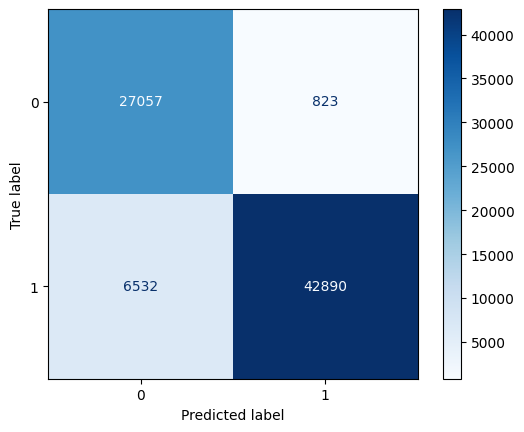

In [8]:
# Hyperparameters
epochs = 10
batch_size = 128
initial_lr = 0.01

# Function which will decrease the lr by 10% every n epochs
def lr_step_decay(epoch, lr):
    epochs_per_drop = 5
    return initial_lr * math.pow(0.9, math.floor(epoch/epochs_per_drop))

# Model

model3 = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(52, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(52, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(12, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(1),
    layers.Activation("sigmoid")
])

model3.summary()

# Compile model
model3.compile(
    optimizer = SGD(learning_rate=initial_lr, momentum=0.9),
    loss = "binary_crossentropy",
    metrics = ["accuracy", "Recall","Precision"]
)

# Train model with proper callback
model3.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, class_weight=class_weights, verbose=1, callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)])

# Evaluate on test data
print("\nTest data loss/accuracy:")
print(model3.evaluate(X_test, y_test))
# Display confusion matrix
display_confusion_matrix((model3.predict(X_test, verbose=0).flatten() > 0.5), y_test)

(180371, 52)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 52)                2756      
                                                                 
 dropout_6 (Dropout)         (None, 52)                0         
                                                                 
 dense_16 (Dense)            (None, 52)                2756      
                                                                 
 dropout_7 (Dropout)         (None, 52)                0         
                                                                 
 dense_17 (Dense)            (None, 12)                636       
                                                                 
 dense_18 (Dense)            (None, 12)                156       
                                                                 
 dense_19 (Dense)            (None, 1)   

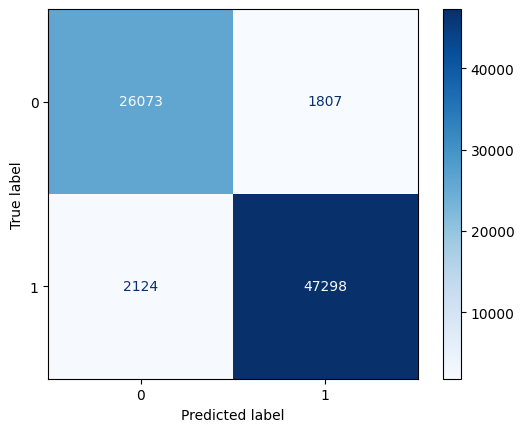

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_hats = model.predict(X_train)
y_hats_test = model.predict(X_test)

# Add the predictions to the training set
X_train = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())
X_train['preds'] = y_hats.tolist()
X_test['preds'] = y_hats_test.tolist()

print(X_train.shape)

# Hyperparameters
epochs = 10
batch_size = 128
initial_lr = 0.01

# Function which will decrease the lr by 10% every n epochs
def lr_step_decay(epoch, lr):
    epochs_per_drop = 5
    return initial_lr * math.pow(0.9, math.floor(epoch/epochs_per_drop))

# Model

model4 = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(52, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(52, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(12, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(1),
    layers.Activation("sigmoid")
])

model4.summary()

# Compile model
model4.compile(
    optimizer = SGD(learning_rate=initial_lr, momentum=0.9),
    loss = "binary_crossentropy",
    metrics = ["accuracy", "Recall","Precision"]
)

# Train model with proper callback
model4.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, class_weight=class_weights, verbose=1, callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)])

# Evaluate on test data
print("\nTest data loss/accuracy:")
print(model4.evaluate(X_test, y_test))
# Display confusion matrix
display_confusion_matrix((model4.predict(X_test, verbose=0).flatten() > 0.5), y_test)

In [10]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_hats = model.predict(X_train)
y_hats_test = model.predict(X_test)

# Add the predictions to the training set
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train['preds'] = y_hats.tolist()
X_test['preds'] = y_hats_test.tolist()

#######


model = KMeans(n_clusters=2, random_state=0)
model.fit(X_train, y_train)

y_hats = model.predict(X_train)
y_hats_test = model.predict(X_test)

# Add the predictions to the training set
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train['preds2'] = y_hats.tolist()
X_test['preds2'] = y_hats_test.tolist()


########

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_hats = model.predict(X_train)
y_hats_test = model.predict(X_test)

# Add the predictions to the training set
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train['preds3'] = y_hats.tolist()
X_test['preds3'] = y_hats_test.tolist()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 52)                2860      
                                                                 
 dropout_8 (Dropout)         (None, 52)                0         
                                                                 
 dense_21 (Dense)            (None, 52)                2756      
                                                                 
 dropout_9 (Dropout)         (None, 52)                0         
                                                                 
 dense_22 (Dense)            (None, 12)                636       
                                                                 
 dense_23 (Dense)            (None, 12)                156       
                                                                 
 dense_24 (Dense)            (None, 1)                

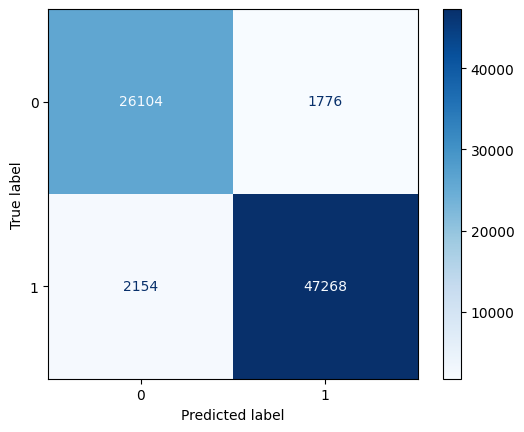

In [11]:
# Hyperparameters
epochs = 10
batch_size = 128
initial_lr = 0.01

# Function which will decrease the lr by 10% every n epochs
def lr_step_decay(epoch, lr):
    epochs_per_drop = 5
    return initial_lr * math.pow(0.9, math.floor(epoch/epochs_per_drop))

# Model

model5 = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(52, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(52, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(12, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(1),
    layers.Activation("sigmoid")
])

model5.summary()

# Compile model
model5.compile(
    optimizer = SGD(learning_rate=initial_lr, momentum=0.9),
    loss = "binary_crossentropy",
    metrics = ["accuracy", "Recall","Precision"]
)

# Train model with proper callback
model5.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, class_weight=class_weights, verbose=1, callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)])

# Evaluate on test data
print("\nTest data loss/accuracy:")
print(model5.evaluate(X_test, y_test))
# Display confusion matrix
display_confusion_matrix((model5.predict(X_test, verbose=0).flatten() > 0.5), y_test)